# **CIS 5300 Final Project**

By: Chanya (Grace) Thanglerdsumpan, Ethan Zhao, Eric Wang, Angie Cao, and Jeremy Calcarian


# Introduction


***Motivation:***
We are 5 out of the 310 million users on Amazon. Ever since the pandemic, e-commerce has been growing significantly, gaining traction over brick and mortar and retail stores. Given the benefits of being able to conveniently browse through products and prices and the convenience of fast deliveries; online stores such as Amazon have gained million of users.

One of the main disadvantage of online shopping is being unable to touch, see, or try on the products in real life. As a result, buyers have been relying on reviews from other buyers to make their purchasing decision. With the recent rise of LLM and AI tools that can mimick humans, we want to create models that can analyze and classify whether a review is computer-generated or not.

Overall, we hope to be able to help users better understand products and improve the trustworthiness of these reviews by building models that can detect machine-generated ones.






**Objective**: Our term project aims to create a model that can detect and analyze patterns that distinguish genuine, human-written Amazon reviews from fake, computer-generated ones.

Using a fake review dataset from Amazon, we build models from simple baseline that has 95% accuracy on detecting these fake reviews.





# Installs and Imports

In [ ]:
!pip install pandasql
!pip install eli5
!pip install textstat

In [ ]:
import csv
import pandas as pd
import numpy as np
import datetime as dt
import geopy.distance as gp
import matplotlib.image as mpimg
import plotly.express as px
import pandasql as ps
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import os
import tarfile

# Collecting Data

In [ ]:
# Mount to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Initialize our dataframe using our downloaded csv
tar_file_path = '/content/drive/MyDrive/CIS5300 final project/data.tar.gz'
output_dir = '/content/extracted_files'

os.makedirs(output_dir, exist_ok=True)

with tarfile.open(tar_file_path, 'r') as tar:
    tar.extractall(path=output_dir)
    print("Extracted files:", tar.getnames())

import glob

csv_files = glob.glob(f"{output_dir}/*.csv")
print("CSV files found:", csv_files)

import pandas as pd

if csv_files:
    df = pd.read_csv(csv_files[0])
    print(df.head())

train_path = '/content/extracted_files/data/train/train.csv'
dev_path = '/content/extracted_files/data/dev/dev.csv'
test_path = '/content/extracted_files/data/test/test.csv'
train_df = pd.read_csv(train_path)
dev_df = pd.read_csv(dev_path)
test_df = pd.read_csv(test_path)

Extracted files: ['data', 'data/dev', 'data/dev/dev.csv', 'data/test', 'data/test/test.csv', 'data/train', 'data/train/train.csv']
CSV files found: []


In [ ]:
train_df.head(10)

,category,rating,label,text_
0,Toys_and_Games_5,5.0,CG,"The box is awesome and looks great, the materi..."
1,Tools_and_Home_Improvement_5,5.0,CG,We used this to put some of the pieces on a sh...
2,Books_5,4.0,OR,"I loved the suspense, will look forward to the..."
3,Sports_and_Outdoors_5,5.0,OR,This has worked well for me. It does exactly ...
4,Kindle_Store_5,1.0,CG,"Ok so I cant say what happens, but it is good...."
5,Toys_and_Games_5,3.0,CG,My 7-year-old loves to sit and play with the w...
6,Movies_and_TV_5,5.0,CG,One of our favorite movies. Excellent family ...
7,Books_5,5.0,CG,"If you like detective stories, this is the boo..."
8,Tools_and_Home_Improvement_5,5.0,CG,I installed these bulbs in a dimmable fixture ...
9,Books_5,5.0,OR,I bought this book because I heard that it ins...


In [ ]:
TEXT_COLUMN = 'text_'
LABEL_COLUMN = 'label'

encoded_label_dict = {'CG': 0, 'OR': 1}

In [ ]:
def encode_label(x):
    return encoded_label_dict.get(x, -1)

# Apply label encoding to the datasets
train_df['target'] = train_df[LABEL_COLUMN].apply(encode_label)
dev_df['target'] = dev_df[LABEL_COLUMN].apply(encode_label)
test_df['target'] = test_df[LABEL_COLUMN].apply(encode_label)

In [ ]:
# Handle missing values in the text data
train_df[TEXT_COLUMN].fillna('unknown', inplace=True)
dev_df[TEXT_COLUMN].fillna('unknown', inplace=True)
test_df[TEXT_COLUMN].fillna('unknown', inplace=True)

<ipython-input-8-b15695b0b9f2>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[TEXT_COLUMN].fillna('unknown', inplace=True)
<ipython-input-8-b15695b0b9f2>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

# Models
Other than the simple baseline that we have implemented, we decided to implement a strong baseline based on the publication that we have studied, which uses logistic regression and Naive Bayes. From reading the publications and empirical data, we noticed the accuracy increase from vectorizing the data beforehand. Hence, one of the strong baseline models will be a logistic regression classifier with TF-IDF vectorizing only.

For the two extensions, we will build off of this strong baseline model by using (1) feature extraction and (2) GloVe embeddings.

## Strong Baseline Model (TF-IDF)

In [ ]:
# Define a tokenizer that separates punctuation
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s):
    return re_tok.sub(r' \1 ', s).split()

In [ ]:
vec = TfidfVectorizer(
    ngram_range=(1,2),
    tokenizer=tokenize,
    min_df=3,
    max_df=0.9,
    strip_accents='unicode',
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True
)

In [ ]:
# Fit and transform the data
X_train_tfidf = vec.fit_transform(train_df[TEXT_COLUMN])
X_dev_tfidf = vec.transform(dev_df[TEXT_COLUMN])
X_test_tfidf = vec.transform(test_df[TEXT_COLUMN])

y_train = train_df['target'].values
y_dev = dev_df['target'].values
y_test = test_df['target'].values

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### Train Baseline

In [ ]:
# Train baseline
baseline_clf = LogisticRegression(max_iter=1000, random_state=42)
baseline_clf.fit(X_train_tfidf, y_train)

# Make predictions on dev data
y_dev_pred = baseline_clf.predict(X_dev_tfidf)

### Evaluation of Strong Baseline (Dev)

Baseline TF-IDF Model Performance on Dev Set
Accuracy: 0.938
Classification Report:
               precision    recall  f1-score   support

          CG       0.96      0.92      0.94      2003
          OR       0.92      0.96      0.94      1997

    accuracy                           0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000


Confusion Matrix:


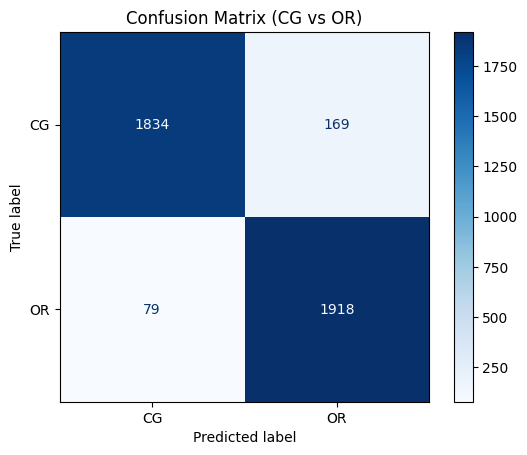

In [ ]:
# Evaluate on Dev
print("Baseline TF-IDF Model Performance on Dev Set")
print("Accuracy:", accuracy_score(y_dev, y_dev_pred))
print("Classification Report:\n", classification_report(y_dev, y_dev_pred, target_names=encoded_label_dict.keys()))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_dev, y_dev_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["CG", "OR"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (CG vs OR)")
plt.show()

In [ ]:
# Predict on test data
y_test_pred = baseline_clf.predict(X_test_tfidf)

### Evaluation of Strong Baseline (Test)

Baseline TF-IDF Model Performance on Test Set
Accuracy: 0.94175
Classification Report:
               precision    recall  f1-score   support

          CG       0.96      0.93      0.94      2021
          OR       0.93      0.96      0.94      1979

    accuracy                           0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000


Confusion Matrix:


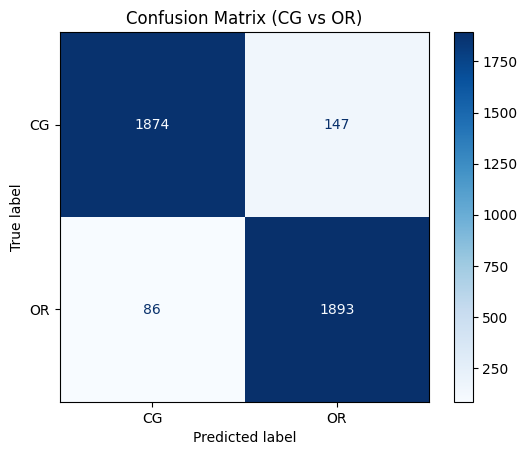

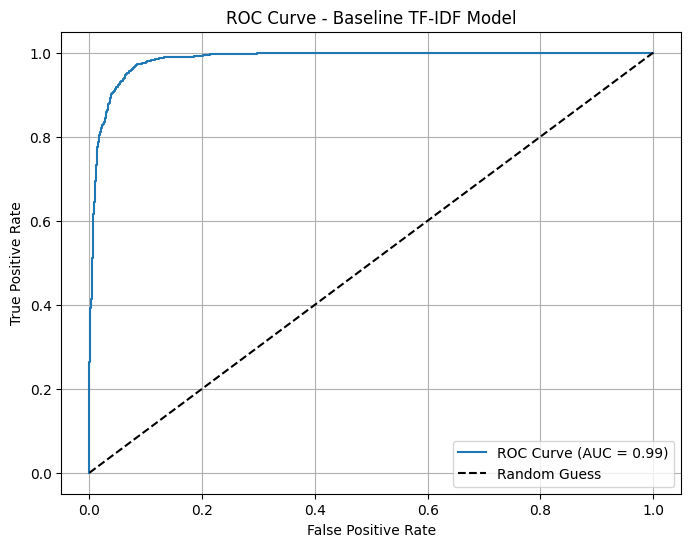

ROC AUC Score: 0.9850090972529723


In [ ]:
# Evaluate
print("Baseline TF-IDF Model Performance on Test Set")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred, target_names=encoded_label_dict.keys()))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["CG", "OR"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (CG vs OR)")
plt.show()

y_test_proba = baseline_clf.predict_proba(X_test_tfidf)[:, 1]  # Probability of OR
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Baseline TF-IDF Model')
plt.legend()
plt.grid(True)
plt.show()

print("ROC AUC Score:", roc_auc)

# TF-IDF + Extracted Features

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import numpy as np
import textstat
from textblob import TextBlob
import spacy
nlp = spacy.load("en_core_web_sm")
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))

def text_features(text):
    words = word_tokenize(text)
    sentences = sent_tokenize(text)
    punct_count = sum([1 for c in text if c in string.punctuation])
    unique_words = len(set(words))
    return {
        'char_count': len(text),
        'word_count': len(words),
        'sentence_count': len(sentences),
        'avg_word_length': np.mean([len(w) for w in words]) if words else 0,
        'unique_word_ratio': unique_words / len(words) if words else 0,
        'stopword_ratio': len([w for w in words if w.lower() in stop_words]) / len(words) if words else 0,
        'punctuation_count': punct_count
    }

def sentiment_features(text):
    analysis = TextBlob(text)
    return {
        'sentiment_polarity': analysis.sentiment.polarity,
        'sentiment_subjectivity': analysis.sentiment.subjectivity
    }

def linguistic_features(text):
    readability = {
        "flesch_reading_ease": textstat.flesch_reading_ease(text),
        "flesch_kincaid_grade": textstat.flesch_kincaid_grade(text),
        "gunning_fog_index": textstat.gunning_fog(text),
        "smog_index": textstat.smog_index(text),
        "coleman_liau_index": textstat.coleman_liau_index(text),
        "automated_readability_index": textstat.automated_readability_index(text),
    }

    return {
        "flesch_reading_ease": readability["flesch_reading_ease"],
        "flesch_kincaid_grade": readability["flesch_kincaid_grade"],
        "gunning_fog_index": readability["gunning_fog_index"],
        "smog_index": readability["smog_index"],
        "coleman_liau_index": readability["coleman_liau_index"],
        "automated_readability_index": readability["automated_readability_index"]
    }

def extract_all_features(df):
    text_f = df[TEXT_COLUMN].apply(text_features).apply(pd.Series)
    sentiment_f = df[TEXT_COLUMN].apply(sentiment_features).apply(pd.Series)
    linguistic_f = df[TEXT_COLUMN].apply(linguistic_features).apply(pd.Series)
    return pd.concat([text_f, sentiment_f, linguistic_f], axis=1)

train_feats = extract_all_features(train_df)
dev_feats = extract_all_features(dev_df)
test_feats = extract_all_features(test_df)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


### Train Model

In [ ]:
# Combine TF-IDF and extracted features
from scipy.sparse import hstack

X_train_combined = hstack([X_train_tfidf, np.array(train_feats)])
X_dev_combined = hstack([X_dev_tfidf, np.array(dev_feats)])
X_test_combined = hstack([X_test_tfidf, np.array(test_feats)])

# Train model
combined_clf = LogisticRegression(max_iter=1000, random_state=42)
combined_clf.fit(X_train_combined, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
y_dev_pred_combined = combined_clf.predict(X_dev_combined)

### Evaluate on Extension 1 (Dev)

TF-IDF + Extracted Features Model Performance on Dev Set
Accuracy: 0.87
Classification Report:
               precision    recall  f1-score   support

          CG       0.88      0.86      0.87      2003
          OR       0.86      0.88      0.87      1997

    accuracy                           0.87      4000
   macro avg       0.87      0.87      0.87      4000
weighted avg       0.87      0.87      0.87      4000


Confusion Matrix:


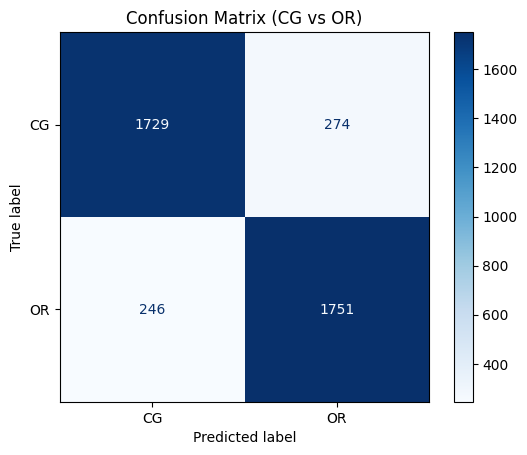

In [ ]:
# Evaluate on dev
print("TF-IDF + Extracted Features Model Performance on Dev Set")
print("Accuracy:", accuracy_score(y_dev, y_dev_pred_combined))
print("Classification Report:\n", classification_report(y_dev, y_dev_pred_combined, target_names=encoded_label_dict.keys()))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_dev, y_dev_pred_combined)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["CG", "OR"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (CG vs OR)")
plt.show()

In [ ]:
y_test_pred_combined = combined_clf.predict(X_test_combined)

### Evaluate on Extension 1 (Test)

TF-IDF + Extracted Features Model Performance on Test Set
Accuracy: 0.87975
Classification Report:
               precision    recall  f1-score   support

          CG       0.88      0.88      0.88      2021
          OR       0.88      0.88      0.88      1979

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000


Confusion Matrix:


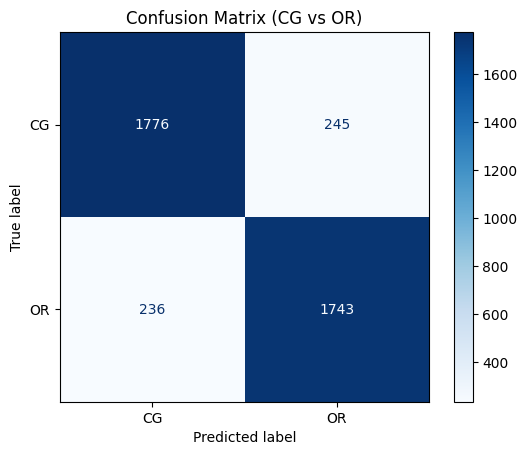

In [ ]:
# Evaluate on test
print("TF-IDF + Extracted Features Model Performance on Test Set")
print("Accuracy:", accuracy_score(y_test, y_test_pred_combined))
print("Classification Report:\n", classification_report(y_test, y_test_pred_combined, target_names=encoded_label_dict.keys()))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred_combined)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["CG", "OR"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (CG vs OR)")
plt.show()

### Evaluation on Extracted Features (No TF-IDF)

In [ ]:
# Train using extracted features only
extracted_clf = LogisticRegression(max_iter=1000, random_state=42)
extracted_clf.fit(train_feats, y_train)

# Evaluate on the test set
y_test_pred_extracted = extracted_clf.predict(test_feats)
print("Accuracy (Extracted Features Only):", accuracy_score(y_test, y_test_pred_extracted))
print("Classification Report:\n", classification_report(y_test, y_test_pred_extracted, target_names=encoded_label_dict.keys()))

Accuracy (Extracted Features Only): 0.797
Classification Report:
               precision    recall  f1-score   support

          CG       0.80      0.80      0.80      2021
          OR       0.80      0.79      0.79      1979

    accuracy                           0.80      4000
   macro avg       0.80      0.80      0.80      4000
weighted avg       0.80      0.80      0.80      4000



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### SHAP Summary

  0%|          | 0/100 [00:00<?, ?it/s]

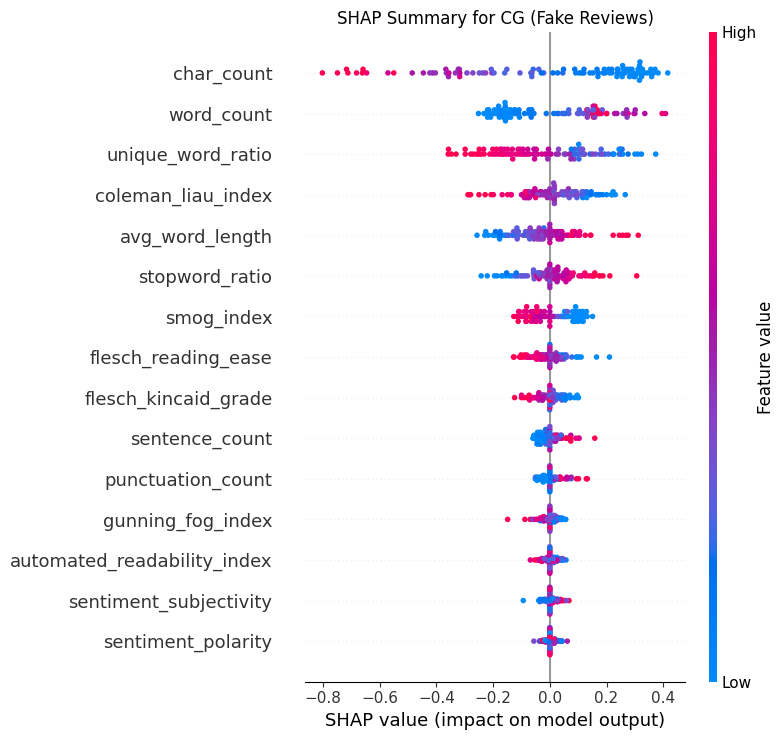

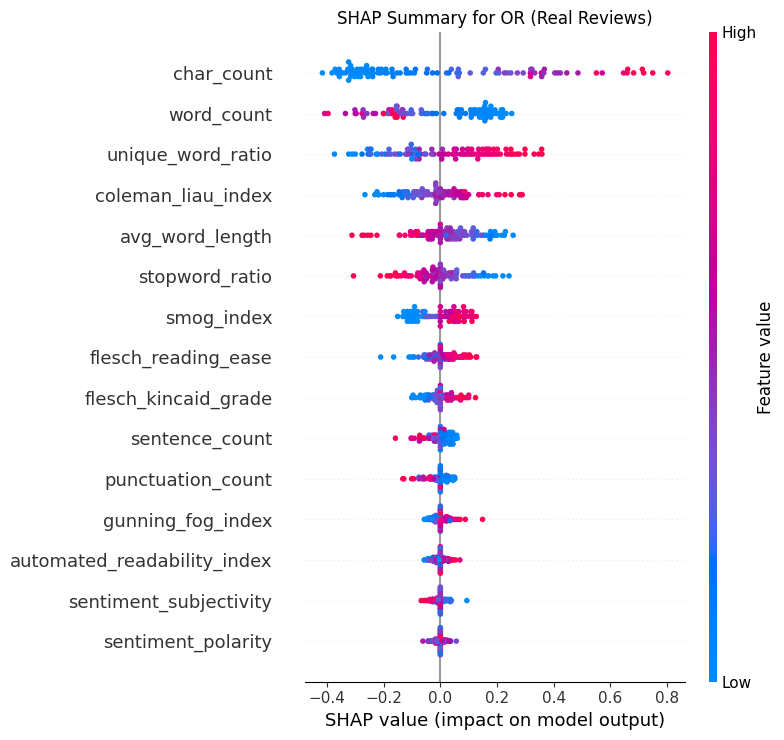

In [ ]:
import shap
import matplotlib.pyplot as plt

shap.initjs()

X_test_extracted = test_feats.values

explainer_extracted = shap.KernelExplainer(
    extracted_clf.predict_proba,
    train_feats.values[:1000]  # Use a subset
)

# Calculate SHAP values
shap_values_extracted = explainer_extracted.shap_values(X_test_extracted[:100], nsamples=100)


shap_values_for_class_CG = shap_values_extracted[:, :, 0]
shap_values_for_class_OR = shap_values_extracted[:, :, 1]

#Plots
plt.title("SHAP Summary for CG (Fake Reviews)")
shap.summary_plot(
    shap_values_for_class_CG,
    X_test_extracted[:100],
    feature_names=test_feats.columns
)

plt.title("SHAP Summary for OR (Real Reviews)")
shap.summary_plot(
    shap_values_for_class_OR,
    X_test_extracted[:100],
    feature_names=test_feats.columns
)


# TF-IDF + GloVe Embeddings

In [ ]:
#get 6B glove embeddings
!wget -nc https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!ls -lat

--2024-12-19 21:00:56--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-12-19 21:00:56--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 39s  

2024-12-19 21:03:35 (5.18 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflatin

In [ ]:
# Function to get glove embeddings
def get_glove_embeddings(file_path, embedding_dim=100):
    embeddings_index = {}
    with open(file_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index

In [ ]:
glove_file = "glove.6B.100d.txt"
glove_embeddings = get_glove_embeddings(glove_file, embedding_dim=100)

In [ ]:
def sentence_to_glove_embedding(text, embeddings_index, embedding_dim=100):
    words = text.split()
    valid_vectors = [embeddings_index[word] for word in words if word in embeddings_index]
    if valid_vectors:
        return np.mean(valid_vectors, axis=0)
    else:
        return np.zeros(embedding_dim)

In [ ]:
train_glove_features = train_df[TEXT_COLUMN].apply(lambda x: sentence_to_glove_embedding(x, glove_embeddings, 100))
dev_glove_features = dev_df[TEXT_COLUMN].apply(lambda x: sentence_to_glove_embedding(x, glove_embeddings, 100))
test_glove_features = test_df[TEXT_COLUMN].apply(lambda x: sentence_to_glove_embedding(x, glove_embeddings, 100))

train_glove_df = pd.DataFrame(train_glove_features.tolist(), columns=[f"glove_{i}" for i in range(100)])
dev_glove_df = pd.DataFrame(dev_glove_features.tolist(), columns=[f"glove_{i}" for i in range(100)])
test_glove_df = pd.DataFrame(test_glove_features.tolist(), columns=[f"glove_{i}" for i in range(100)])

# Combine TF-IDF, Extracted Features, and GloVe
X_train_final = hstack([X_train_tfidf, np.array(train_glove_df)])
X_dev_final = hstack([X_dev_tfidf, np.array(dev_glove_df)])
X_test_final = hstack([X_test_tfidf, np.array(test_glove_df)])

In [ ]:
final_clf = LogisticRegression(max_iter=1000, random_state=42)
final_clf.fit(X_train_final, y_train)

In [ ]:
y_dev_pred_final = final_clf.predict(X_dev_final)

### Evaluation of Extension 2 (Dev)

TF-IDF + Extracted Features + GloVe Model Performance on Dev Set
Accuracy: 0.93675
Classification Report:
               precision    recall  f1-score   support

          CG       0.95      0.92      0.94      2003
          OR       0.92      0.95      0.94      1997

    accuracy                           0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000


Confusion Matrix:


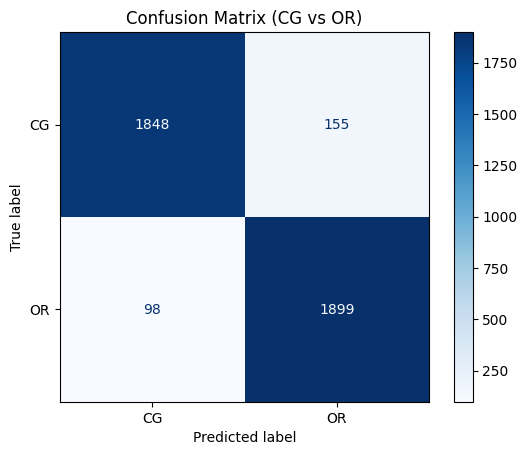

In [ ]:
# Evaluate
print("TF-IDF + Extracted Features + GloVe Model Performance on Dev Set")
print("Accuracy:", accuracy_score(y_dev, y_dev_pred_final))
print("Classification Report:\n", classification_report(y_dev, y_dev_pred_final, target_names=encoded_label_dict.keys()))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_dev, y_dev_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["CG", "OR"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (CG vs OR)")
plt.show()

In [ ]:
y_test_pred_final = final_clf.predict(X_test_final)

### Evaluation of Extension 2 (Dev)

Final Model Performance on Test Set
Accuracy: 0.93525
Classification Report:
               precision    recall  f1-score   support

          CG       0.95      0.92      0.94      2021
          OR       0.92      0.95      0.94      1979

    accuracy                           0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000


Confusion Matrix:


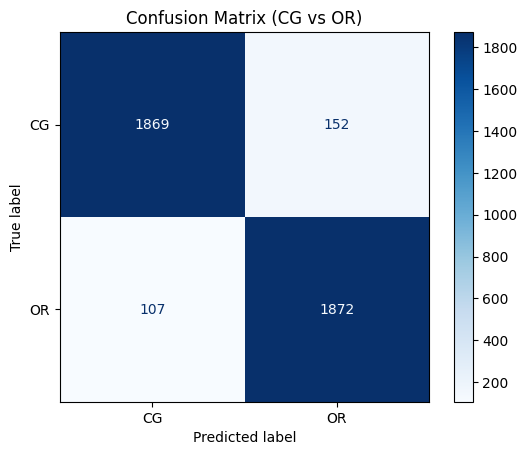

In [ ]:
# Evaluate final model on test set
print("Final Model Performance on Test Set")
print("Accuracy:", accuracy_score(y_test, y_test_pred_final))
print("Classification Report:\n", classification_report(y_test, y_test_pred_final, target_names=encoded_label_dict.keys()))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["CG", "OR"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (CG vs OR)")
plt.show()

## Error Evaluation

In [ ]:
# Categorize errors for the final model
final_fp = np.where((y_test_pred_final == 0) & (y_test == 1))[0]  # False Positives: Predicted CG, Actual OR
final_fn = np.where((y_test_pred_final == 1) & (y_test == 0))[0]  # False Negatives: Predicted OR, Actual CG

baseline_fp = np.where((y_test_pred == 0) & (y_test == 1))[0]
baseline_fn = np.where((y_test_pred == 1) & (y_test == 0))[0]

corrected_by_final = np.setdiff1d(np.where(y_test_pred != y_test)[0], np.where(y_test_pred_final != y_test)[0])
worsened_by_final = np.setdiff1d(np.where(y_test_pred_final != y_test)[0], np.where(y_test_pred != y_test)[0])

corrected_CG = corrected_by_final[y_test[corrected_by_final] == 0]
corrected_OR = corrected_by_final[y_test[corrected_by_final] == 1]

worsened_CG = worsened_by_final[y_test[worsened_by_final] == 0]
worsened_OR = worsened_by_final[y_test[worsened_by_final] == 1]

# Examples of errors corrected and worsened
print("\nExamples of CG (Computer-Generated) Errors Corrected by Final Model:")
for idx in corrected_CG[:5]:
    print(f"Text: {test_df.iloc[idx][TEXT_COLUMN]}")
    print(f"Actual Label: {y_test[idx]}, Baseline Prediction: {y_test_pred[idx]}, Final Prediction: {y_test_pred_final[idx]}")
    print("---")

print("\nExamples of OR (Original) Errors Corrected by Final Model:")
for idx in corrected_OR[:5]:
    print(f"Text: {test_df.iloc[idx][TEXT_COLUMN]}")
    print(f"Actual Label: {y_test[idx]}, Baseline Prediction: {y_test_pred[idx]}, Final Prediction: {y_test_pred_final[idx]}")
    print("---")

print("\nExamples of CG (Computer-Generated) Errors Worsened by Final Model:")
for idx in worsened_CG[:10]:
    print(f"Text: {test_df.iloc[idx][TEXT_COLUMN]}")
    print(f"Actual Label: {y_test[idx]}, Baseline Prediction: {y_test_pred[idx]}, Final Prediction: {y_test_pred_final[idx]}")
    print("---")

print("\nExamples of OR (Original) Errors Worsened by Final Model:")
for idx in worsened_OR[:5]:
    print(f"Text: {test_df.iloc[idx][TEXT_COLUMN]}")
    print(f"Actual Label: {y_test[idx]}, Baseline Prediction: {y_test_pred[idx]}, Final Prediction: {y_test_pred_final[idx]}")
    print("---")


# CG: 0, OR: 1


Examples of CG (Computer-Generated) Errors Corrected by Final Model:
Text: I love this seroes the way it is written and you can't help but feel the emotions and the growing
Actual Label: 0, Baseline Prediction: 1, Final Prediction: 0
---
Text: I have several dogs and this has been an important part of our growing dog's life.
Actual Label: 0, Baseline Prediction: 1, Final Prediction: 0
---
Text: Quite easy installation. Solar Power (Cordless) is included.  There is a built-
Actual Label: 0, Baseline Prediction: 1, Final Prediction: 0
---
Text: Durable and high quality. Our dog has been on the fence for a long time, and this
Actual Label: 0, Baseline Prediction: 1, Final Prediction: 0
---
Text: Added 64GB to a 2017 MacBook Pro, with a 128GB SSD.
Actual Label: 0, Baseline Prediction: 1, Final Prediction: 0
---

Examples of OR (Original) Errors Corrected by Final Model:
Text: These are great baselayer for the colder weather. I use them for hiking or by theirself for exercising.  I will be

## Downloading Output
Please run the block below to download the outputs from each model locally to your drive

In [ ]:
# change folder path as needed
folder_path = "/content/drive/My Drive/"

### Downloading Output for Strong Baseline (Dev)

In [ ]:
y_dev_proba = baseline_clf.predict_proba(X_dev_tfidf)[:, 1] # probability of predicted positive classes

dev_predictions_df = pd.DataFrame({
    "Text": dev_df[TEXT_COLUMN],
    "True_Label": y_dev,
    "Predicted_Label": y_dev_pred,
    "Probability_OR": y_dev_proba
})

# output_file = "dev_predictions_strong_baseline.csv"
output_file = folder_path + "dev_predictions_strong_baseline.csv"
dev_predictions_df.to_csv(output_file, index=False)

print(f"Development set predictions saved to {output_file}.")


### Downloading Output for Strong Baseline (Dev)

In [ ]:
y_test_proba = baseline_clf.predict_proba(X_test_tfidf)[:, 1] # Probabilities for the positive class

test_results_df = pd.DataFrame({
    "True_Label": y_test,
    "Predicted_Label": y_test_pred,
    "Probability_OR": y_test_proba
})

output_file = folder_path + "test_predictions_strong_baseline.csv"
test_results_df.to_csv(output_file, index=False)

print(f"Test predictions have been saved to {output_file}")

### Downloading Output for Extension 1 (Dev)

In [ ]:
y_dev_proba_combined = combined_clf.predict_proba(X_dev_combined)[:, 1]

dev_predictions_combined_df = pd.DataFrame({
    "Text": dev_df[TEXT_COLUMN],
    "True_Label": y_dev,
    "Predicted_Label": y_dev_pred_combined,
    "Probability_OR": y_dev_proba_combined
})

output_file_combined = folder_path + "dev_predictions_extension_1_model.csv"
dev_predictions_combined_df.to_csv(output_file_combined, index=False)

print(f"Development set predictions for combined model saved to {output_file_combined}.")

### Downloading Output for Extension 1 (Test)

In [ ]:
y_test_proba_combined = combined_clf.predict_proba(X_test_combined)[:, 1]

test_predictions_combined_df = pd.DataFrame({
    "Text": dev_df[TEXT_COLUMN],
    "True_Label": y_test,
    "Predicted_Label": y_dev_pred_combined,
    "Probability_OR": y_dev_proba_combined
})

output_file_combined = folder_path + "test_predictions_extension_1_model.csv"
test_predictions_combined_df.to_csv(output_file_combined, index=False)

print(f"Test set predictions for combined model saved to {output_file_combined}.")

### Downloading Output for Extension 2 (Dev)

In [ ]:
y_dev_proba_final = final_clf.predict_proba(X_dev_final)[:, 1]

dev_predictions_final_df = pd.DataFrame({
    "Text": dev_df[TEXT_COLUMN],
    "True_Label": y_dev,
    "Predicted_Label": y_dev_pred_final,
    "Probability_OR": y_dev_proba_final
})

dev_output_file = folder_path + "dev_predictions_final_model.csv"
dev_predictions_final_df.to_csv(dev_output_file, index=False)
print(f"Development set predictions for the final model saved to {dev_output_file}.")

### Downloading Output for Extension 2 (Test)

In [ ]:
y_test_proba_final = final_clf.predict_proba(X_test_final)[:, 1]


test_predictions_final_df = pd.DataFrame({
    "Text": test_df[TEXT_COLUMN],
    "True_Label": y_test,
    "Predicted_Label": y_test_pred_final,
    "Probability_OR": y_test_proba_final
})

test_output_file = folder_path + "test_predictions_final_model.csv"
test_predictions_final_df.to_csv(test_output_file, index=False)
print(f"Test set predictions for the final model saved to {test_output_file}.")